In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from xgboost import XGBRegressor
import shap

## Reading data

In [34]:
data = pd.read_csv("states_all.csv")
data

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,NaN,NaN,731634.0,208.0,252.0,207.0,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,NaN,NaN,122487.0,NaN,NaN,NaN,NaN
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,NaN,NaN,673477.0,215.0,265.0,209.0,NaN
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,NaN,NaN,441490.0,210.0,256.0,211.0,NaN
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,NaN,NaN,5254844.0,208.0,261.0,202.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710,2019_VIRGINIA,VIRGINIA,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,247.0,287.0,224.0,262.0
1711,2019_WASHINGTON,WASHINGTON,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,240.0,286.0,220.0,266.0
1712,2019_WEST_VIRGINIA,WEST_VIRGINIA,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,231.0,272.0,213.0,256.0
1713,2019_WISCONSIN,WISCONSIN,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,242.0,289.0,220.0,267.0


In [35]:
data.keys().to_list()

['PRIMARY_KEY',
 'STATE',
 'YEAR',
 'ENROLL',
 'TOTAL_REVENUE',
 'FEDERAL_REVENUE',
 'STATE_REVENUE',
 'LOCAL_REVENUE',
 'TOTAL_EXPENDITURE',
 'INSTRUCTION_EXPENDITURE',
 'SUPPORT_SERVICES_EXPENDITURE',
 'OTHER_EXPENDITURE',
 'CAPITAL_OUTLAY_EXPENDITURE',
 'GRADES_PK_G',
 'GRADES_KG_G',
 'GRADES_4_G',
 'GRADES_8_G',
 'GRADES_12_G',
 'GRADES_1_8_G',
 'GRADES_9_12_G',
 'GRADES_ALL_G',
 'AVG_MATH_4_SCORE',
 'AVG_MATH_8_SCORE',
 'AVG_READING_4_SCORE',
 'AVG_READING_8_SCORE']

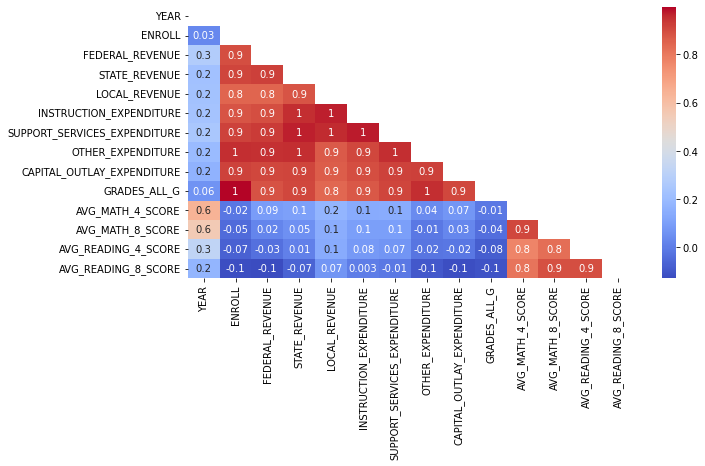

In [36]:
fig, ax = plt.subplots(figsize=(10,5))
matrix = np.triu(data[cols].corr())
ax = sns.heatmap(data[cols].corr(), annot = True, fmt='.1g',cmap= 'coolwarm',mask=matrix)

## Counting NaN Values

In [37]:
data.isna().sum()

PRIMARY_KEY                        0
STATE                              0
YEAR                               0
ENROLL                           491
TOTAL_REVENUE                    440
FEDERAL_REVENUE                  440
STATE_REVENUE                    440
LOCAL_REVENUE                    440
TOTAL_EXPENDITURE                440
INSTRUCTION_EXPENDITURE          440
SUPPORT_SERVICES_EXPENDITURE     440
OTHER_EXPENDITURE                491
CAPITAL_OUTLAY_EXPENDITURE       440
GRADES_PK_G                      173
GRADES_KG_G                       83
GRADES_4_G                        83
GRADES_8_G                        83
GRADES_12_G                       83
GRADES_1_8_G                     695
GRADES_9_12_G                    644
GRADES_ALL_G                      83
AVG_MATH_4_SCORE                1150
AVG_MATH_8_SCORE                1113
AVG_READING_4_SCORE             1065
AVG_READING_8_SCORE             1153
dtype: int64

## Removing NaN values from target

Решил выбрать в качестве цели оценки за 8-й класс, потому что я думаю, что лучше оценивать оценки в средней или средней школе. Мы можем спрогнозировать, как наши инвестиции повлияют на уровень знаний учеников.

In [5]:
#data = data[(data['AVG_MATH_8_SCORE'].isna() == False) & (data['AVG_READING_8_SCORE'].isna() == False)]
data = data[(data['AVG_MATH_8_SCORE'].isna() == False)]

In [6]:
cols = ['YEAR',
 'ENROLL',
 'FEDERAL_REVENUE',
 'STATE_REVENUE',
 'LOCAL_REVENUE',
 'INSTRUCTION_EXPENDITURE',
 'SUPPORT_SERVICES_EXPENDITURE',
 'OTHER_EXPENDITURE',
 'CAPITAL_OUTLAY_EXPENDITURE',
 'GRADES_ALL_G',
 'AVG_MATH_4_SCORE',
 'AVG_MATH_8_SCORE',
 'AVG_READING_4_SCORE',
 'AVG_READING_8_SCORE']

In [7]:
data = data[cols]

## Filling NaN

Заполняю пробелы средними значениями

In [8]:
data['ENROLL'] = data['ENROLL'].fillna(data['ENROLL'].mean())
data['FEDERAL_REVENUE'] = data['FEDERAL_REVENUE'].fillna(data['FEDERAL_REVENUE'].mean())
data['STATE_REVENUE'] = data['STATE_REVENUE'].fillna(data['STATE_REVENUE'].mean())
data['LOCAL_REVENUE'] = data['LOCAL_REVENUE'].fillna(data['LOCAL_REVENUE'].mean())
data['INSTRUCTION_EXPENDITURE'] = data['INSTRUCTION_EXPENDITURE'].fillna(data['INSTRUCTION_EXPENDITURE'].mean())
data['SUPPORT_SERVICES_EXPENDITURE'] = data['SUPPORT_SERVICES_EXPENDITURE'].fillna(data['SUPPORT_SERVICES_EXPENDITURE'].mean())
data['OTHER_EXPENDITURE'] = data['OTHER_EXPENDITURE'].fillna(data['OTHER_EXPENDITURE'].mean())
data['CAPITAL_OUTLAY_EXPENDITURE'] = data['CAPITAL_OUTLAY_EXPENDITURE'].fillna(data['CAPITAL_OUTLAY_EXPENDITURE'].mean())
data['GRADES_ALL_G'] = data['GRADES_ALL_G'].fillna(data['GRADES_ALL_G'].mean())

## Pre-processing

In [9]:
X_data = data[['YEAR',
 'ENROLL',
 'FEDERAL_REVENUE',
 'STATE_REVENUE',
 'LOCAL_REVENUE',
 'INSTRUCTION_EXPENDITURE',
 'SUPPORT_SERVICES_EXPENDITURE',
 'OTHER_EXPENDITURE',
 'CAPITAL_OUTLAY_EXPENDITURE',
 'GRADES_ALL_G']] 
Y_data = data['AVG_MATH_8_SCORE'].to_list()

In [10]:
X_data['YEAR'] = data['YEAR'] - data['YEAR'].mean()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
X_data = preprocessing.normalize(X_data,axis = 0)

In [12]:
X_data.shape

(602, 10)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
     X_data, Y_data, test_size=0.3, random_state=42)

## Testing SVM

Выбрал MAE, MSE и MAPE для оценки качества, так как это самые показательные метрики для регрессии 

In [14]:
svm_model = svm.SVR()
mape = -cross_val_score(svm_model,X_train,y_train,cv=4,scoring='neg_mean_absolute_percentage_error').mean()
mae = -cross_val_score(svm_model,X_train,y_train,cv=4,scoring='neg_mean_absolute_error').mean()
mse = -cross_val_score(svm_model,X_train,y_train,cv=4,scoring='neg_mean_squared_error').mean()
print('SVM Errors')
print('MAE:' + str(round(mae,3)) + ' MAPE:' + str(round(mape,3)) + ' MSE:' + str(round(mse,3)))

SVM Errors
MAE:6.465 MAPE:0.024 MSE:76.431


In [15]:
svm_model.fit(X_train,y_train)
mae = mean_absolute_error(y_test,svm_model.predict(X_test)) 
mape = mean_absolute_percentage_error(y_test,svm_model.predict(X_test)) 
mse = mean_squared_error(y_test,svm_model.predict(X_test)) 
print('MAE:' + str(round(mae,3)) + ' MAPE:' + str(round(mape,3)) + ' MSE:' + str(round(mse,3)))

MAE:6.121 MAPE:0.023 MSE:67.871


## XGBoost model

In [16]:
XGB_model = XGBRegressor()
mape = -cross_val_score(XGB_model,X_train,y_train,cv=4,scoring='neg_mean_absolute_percentage_error').mean()
mae = -cross_val_score(XGB_model,X_train,y_train,cv=4,scoring='neg_mean_absolute_error').mean()
mse = -cross_val_score(XGB_model,X_train,y_train,cv=4,scoring='neg_mean_squared_error').mean()
print('SVM Errors')
print('MAE:' + str(round(mae,3)) + ' MAPE:' + str(round(mape,3)) + ' MSE:' + str(round(mse,3)))

SVM Errors
MAE:4.639 MAPE:0.017 MSE:39.966


In [17]:
XGB_model.fit(X_train,y_train)
mae = mean_absolute_error(y_test,XGB_model.predict(X_test)) 
mape = mean_absolute_percentage_error(y_test,XGB_model.predict(X_test)) 
mse = mean_squared_error(y_test,XGB_model.predict(X_test)) 
print('MAE:' + str(round(mae,3)) + ' MAPE:' + str(round(mape,3)) + ' MSE:' + str(round(mse,3)))

MAE:4.454 MAPE:0.016 MSE:35.787


## Trying to make a model with average values per student

In [18]:
data['AVG_ENROLL'] = data['ENROLL'].fillna(data['ENROLL'].mean())
data['AVG_FEDERAL_REVENUE'] = data['FEDERAL_REVENUE'] / data['GRADES_ALL_G']
data['AVG_STATE_REVENUE'] = data['STATE_REVENUE'] / data['GRADES_ALL_G']
data['AVG_LOCAL_REVENUE'] = data['LOCAL_REVENUE'] / data['GRADES_ALL_G']
data['AVG_INSTRUCTION_EXPENDITURE'] = data['INSTRUCTION_EXPENDITURE'] / data['GRADES_ALL_G']
data['AVG_SUPPORT_SERVICES_EXPENDITURE'] = data['SUPPORT_SERVICES_EXPENDITURE'] / data['GRADES_ALL_G']
data['AVG_OTHER_EXPENDITURE'] = data['OTHER_EXPENDITURE'] / data['GRADES_ALL_G']
data['AVG_CAPITAL_OUTLAY_EXPENDITURE'] = data['CAPITAL_OUTLAY_EXPENDITURE'] / data['GRADES_ALL_G']


In [19]:
X_data = data[['YEAR',
 'AVG_ENROLL',
 'AVG_FEDERAL_REVENUE',
 'AVG_STATE_REVENUE',
 'AVG_LOCAL_REVENUE',
 'AVG_INSTRUCTION_EXPENDITURE',
 'AVG_SUPPORT_SERVICES_EXPENDITURE',
 'AVG_OTHER_EXPENDITURE',
 'AVG_CAPITAL_OUTLAY_EXPENDITURE']] 
Y_data = data['AVG_MATH_8_SCORE'].to_list()

In [20]:
X_data['YEAR'] = data['YEAR'] - data['YEAR'].mean()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
X_data = preprocessing.normalize(X_data,axis = 0)

In [22]:
X_data.shape

(602, 9)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
     X_data, Y_data, test_size=0.3, random_state=42)

## Testing SVM

In [24]:
svm_model = svm.SVR()
mape = -cross_val_score(svm_model,X_train,y_train,cv=4,scoring='neg_mean_absolute_percentage_error').mean()
mae = -cross_val_score(svm_model,X_train,y_train,cv=4,scoring='neg_mean_absolute_error').mean()
mse = -cross_val_score(svm_model,X_train,y_train,cv=4,scoring='neg_mean_squared_error').mean()
print('SVM Errors')
print('MAE:' + str(round(mae,3)) + ' MAPE:' + str(round(mape,3)) + ' MSE:' + str(round(mse,3)))

SVM Errors
MAE:6.352 MAPE:0.023 MSE:74.284


In [25]:
svm_model.fit(X_train,y_train)
mae = mean_absolute_error(y_test,svm_model.predict(X_test)) 
mape = mean_absolute_percentage_error(y_test,svm_model.predict(X_test)) 
mse = mean_squared_error(y_test,svm_model.predict(X_test)) 
print('MAE:' + str(round(mae,3)) + ' MAPE:' + str(round(mape,3)) + ' MSE:' + str(round(mse,3)))

MAE:5.888 MAPE:0.022 MSE:62.124


## XGBoost model

In [26]:
XGB_model = XGBRegressor()
mape = -cross_val_score(XGB_model,X_train,y_train,cv=4,scoring='neg_mean_absolute_percentage_error').mean()
mae = -cross_val_score(XGB_model,X_train,y_train,cv=4,scoring='neg_mean_absolute_error').mean()
mse = -cross_val_score(XGB_model,X_train,y_train,cv=4,scoring='neg_mean_squared_error').mean()
print('SVM Errors')
print('MAE:' + str(round(mae,3)) + ' MAPE:' + str(round(mape,3)) + ' MSE:' + str(round(mse,3)))

SVM Errors
MAE:5.322 MAPE:0.019 MSE:52.915


In [27]:
XGB_model.fit(X_train,y_train)
mae = mean_absolute_error(y_test,XGB_model.predict(X_test)) 
mape = mean_absolute_percentage_error(y_test,XGB_model.predict(X_test)) 
mse = mean_squared_error(y_test,XGB_model.predict(X_test)) 
print('MAE:' + str(round(mae,3)) + ' MAPE:' + str(round(mape,3)) + ' MSE:' + str(round(mse,3)))

MAE:4.604 MAPE:0.017 MSE:36.668


Могу сделать вывод о том, что обе модели очень хорошо показали себя на тестовых и тренировочных данных. Даже при условии что занчений было так мало

## SHAP describing features impact

Решил попробовать выяснить влияние признаков на таргет

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


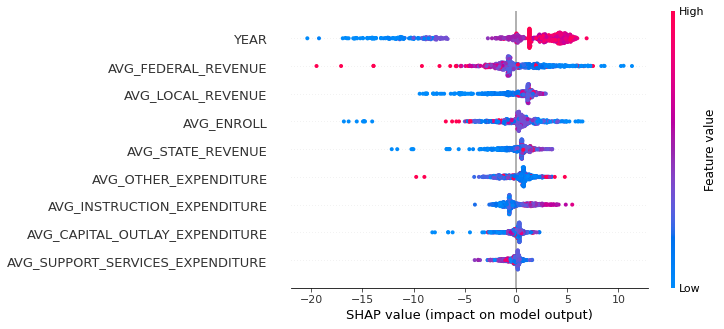

In [33]:
shap_test = shap.TreeExplainer(XGB_model).shap_values(X_data)
shap.summary_plot(shap_test, X_data, feature_names=['YEAR',
 'AVG_ENROLL',
 'AVG_FEDERAL_REVENUE',
 'AVG_STATE_REVENUE',
 'AVG_LOCAL_REVENUE',
 'AVG_INSTRUCTION_EXPENDITURE',
 'AVG_SUPPORT_SERVICES_EXPENDITURE',
 'AVG_OTHER_EXPENDITURE',
 'AVG_CAPITAL_OUTLAY_EXPENDITURE'],
                      max_display=25, auto_size_plot=True)

Как мы видим год влияет больше всего на результат. 